In [1]:
import numpy as np
import pandas as pd

In [2]:
def createTrainSet():
    """
    outlook->  0: sunny | 1: overcast | 2: rain
    temperature-> 0: hot | 1: mild | 2: cool
    humidity-> 0: high | 1: normal
    windy-> 0: false | 1: true
    """
    dataSet = pd.DataFrame([[0, 0, 0, 0, 'N'],
               [0, 0, 0, 1, 'N'],
               [1, 0, 0, 0, 'Y'],
               [2, 1, 0, 0, 'Y'],
               [2, 2, 1, 0, 'Y'],
               [2, 2, 1, 1, 'N'],
               [1, 2, 1, 1, 'Y']],columns = ['outlook', 'temperature', 'humidity', 'windy','label'])
    return dataSet

def createTestSet():
    """
    outlook->  0: sunny | 1: overcast | 2: rain
    temperature-> 0: hot | 1: mild | 2: cool
    humidity-> 0: high | 1: normal
    windy-> 0: false | 1: true
    """
    testSet = pd.DataFrame([[0, 1, 0, 0],
               [0, 2, 1, 0],
               [2, 1, 1, 0],
               [0, 1, 1, 1],
               [1, 1, 0, 1],
               [1, 0, 1, 0],
               [2, 1, 0, 1]],columns = ['outlook', 'temperature', 'humidity', 'windy'])
    return testSet

In [3]:
train_set= createTrainSet()
test_set = createTestSet()
train_set.head()

,outlook,temperature,humidity,windy,label
0,0,0,0,0,N
1,0,0,0,1,N
2,1,0,0,0,Y
3,2,1,0,0,Y
4,2,2,1,0,Y


In [4]:
# 计算信息熵
def entropy(dataset):
    '''
    entropy = -sum(p_i*log(p_i))
    '''
    label_count = dataset.groupby('label').count().iloc[:,1]
    # 计算entropy
    entropy = (-(label_count/label_count.sum())*np.log2(label_count/label_count.sum())).sum()
    return entropy

In [5]:
entropy(train_set)

0.9852281360342515

In [6]:
# 按属性切分数据集并删除该feature
def spilt_dataset(dataset,spilt_feature):
    groups = dataset.groupby(spilt_feature)
    group_dict = {}
    # 用于保存spilt_feature的值，用以生成决策树的分支条件
    for name,group in groups:
        # 删除feature属性列
        group.drop(spilt_feature,inplace = True,axis = 1)
        group_dict[name] = group
    # 返回划分好的属性集，以字典形式，value内是dataframe类型
    return group_dict

In [8]:
group_dict = spilt_dataset(train_set,spilt_feature = 'outlook')
group_dict

{0:    temperature  humidity  windy label
 0            0         0      0     N
 1            0         0      1     N,
 1:    temperature  humidity  windy label
 2            0         0      0     Y
 6            2         1      1     Y,
 2:    temperature  humidity  windy label
 3            1         0      0     Y
 4            2         1      0     Y
 5            2         1      1     N}

In [18]:
# 利用信息增益选择最优的spilt_feature
def select_best_feature(dataset):
    Gain = []
    # 遍历数据集中的feature
    for feature in dataset.columns[0:-1]:
        # 按feature划分数据集
        group_dict = spilt_dataset(train_set,spilt_feature = feature)
        # feature entropy
        feature_entropy = 0
        for group in group_dict.values():
        # 计算按属性划分后的信息增益
            feature_entropy += group.shape[0]/dataset.shape[0]*entropy(group)
        # 计算信息增益添加至Gain_ratio中
        Gain.append(entropy(dataset) - feature_entropy)
    return dataset.columns[Gain.index(max(Gain))],Gain

In [14]:
select_best_feature(train_set)

('outlook',
 [0.5916727785823275,
  0.19811742113040343,
  0.020244207153756077,
  0.12808527889139443])

In [19]:
# 周志华 机器学习 P74
def DecisionTree(dataset,init_dataset = train_set):
    # 若D中样本全部属于同一类别C，node标记为C类结点
    if dataset.label.unique().shape[0] == 1:
        return dataset.iloc[0,-1]
    # 若A = $\empty$ or D中样本在A上取值相同
    # 将结点标记为叶结点，其类别标记为D中样本最多的类
    if dataset.columns[0:-1].shape[0] == 0 or dataset.loc[:,dataset.columns[0:-1]].drop_duplicates().shape[0] == 1:
        # 返回D中样本最多的类
        return dataset['label'].value_counts().index[0]
    #选择最优属性
    spilt_feature,Gain = select_best_feature(dataset)
    # 用最优属性划分D
    subdataset_dict = spilt_dataset(dataset,spilt_feature = spilt_feature)
    # 生成根节点
    dtree = {spilt_feature:{}}
    # !!!!为最优属性的每一个值生成一个结点     
    #@@@@@注意生成分支的时候是利用整个训练集的在spilt feature上value而不是利用spilt_feature_value中的值
    #@@@@@spilt_feature_value经过分支的不断生成，落在一个叶子结点上的sample数量的减少，会有分支缺失的现象
    # total_spilt_feature_value
    spilt_feature_value = init_dataset.loc[:,spilt_feature].unique()
    for feature_value in spilt_feature_value:
        # 若当前subdataset中没有值，即Dv为空，then 将分支结点标记为叶结点，其类别标记为D中样本最多的类
        try:
            dtree[spilt_feature][feature_value] = DecisionTree(subdataset_dict[feature_value])
        except KeyError:
            dtree[spilt_feature][feature_value] = dataset['label'].value_counts().index[0]
    return dtree

In [20]:
# TEST_set = pd.DataFrame([[0,0,0,0,'Y'],
#             [0,0,0,0,'N'],
#             [0,0,0,0,'Y']],columns = ['outlook', 'temperature', 'humidity', 'windy','label'])
# TEST_set.loc[:,TEST_set.columns[0:-1]].drop_duplicates().shape[0] == 1
# DecisionTree(TEST_set)

In [21]:
dtree = DecisionTree(train_set)
dtree

{'outlook': {0: 'N',
  1: 'Y',
  2: {'temperature': {0: 'Y', 1: 'Y', 2: {'windy': {0: 'Y', 1: 'N'}}}}}}

In [22]:
def sample_predict(row,dtree):
    '''
    parameters:
        row:要预测的样本(单个)
        dtree:DecisionTree
    '''
    root_feature = list(dtree.keys())[0]
    root_value = dtree[root_feature]
    # 遍历当前树中所有当前特征的取值
    for feature_value in root_value.keys():
        # 若row在当前特征的取值等于结点的feature
        # print(row)
        if row[root_feature] == feature_value:
            row_class = root_value[feature_value]
            if type(row_class) == dict:
                return sample_predict(row,row_class)
            else:
                return row_class

In [23]:
def predict(dataset,dtree):
    '''
    预测数据集结果
    '''
    predict_result = []
    # print(dataset)
    for index,row in dataset.iterrows():
        predict_result.append(sample_predict(row,dtree))
    return predict_result

In [24]:
predict(test_set,dtree)

['N', 'N', 'Y', 'N', 'Y', 'Y', 'Y']

In [25]:
predict(train_set,dtree)

['N', 'N', 'Y', 'Y', 'Y', 'N', 'Y']

In [26]:
list(train_set.label)

['N', 'N', 'Y', 'Y', 'Y', 'N', 'Y']

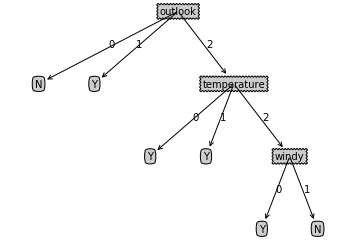

In [28]:
# 可视化
import treePlotter
treePlotter.createPlot(dtree)